## Seattle AirBnB

This notebook is a part from Project 4 in Udacity's Data Scientist Nanodegrees program. The outcome of this project will be posted as a blog post.

I will be working in this datasets from Airbnb homes of Seattle, and exploring throughout this notebook the calendar and listings data homes of Seattle. More details about the project, software, data files, etc are available in the Readme.md file

In [1]:
import pandas as pd
import numpy as np

In [2]:
calendar = pd.read_csv('calendar.csv')

First, let's take a look at the clendar and see how data strcture here.

In [3]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


We can see here how each home in the calendar have the ID, Date, and price.

By looking in price we can see there Nan's values, and Dolar sign that impact in dealing with numeric type

Let's fix that.

In [4]:
def fix_prices(column_name, dataset_name):
    ''' Take a column name and dataset that contain dolar sign and comma,
        The function will update the dataframe with cleaned data.
    '''
    dataset_name[column_name] = dataset_name[column_name].str.replace('$','').str.replace(',','');

def fix_numeric(column_name, dataset_name):
    ''' Take a column name and dataset that are object type,
        The function will change the type to numeric.
    '''
    dataset_name[column_name] = pd.to_numeric(dataset_name[column_name]);

In [5]:
fix_prices('price', calendar)
fix_numeric('price', calendar)
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


Now we have fixed Dolar sign and we have changed type to numeric.

Let's see how this how price perform durring days.

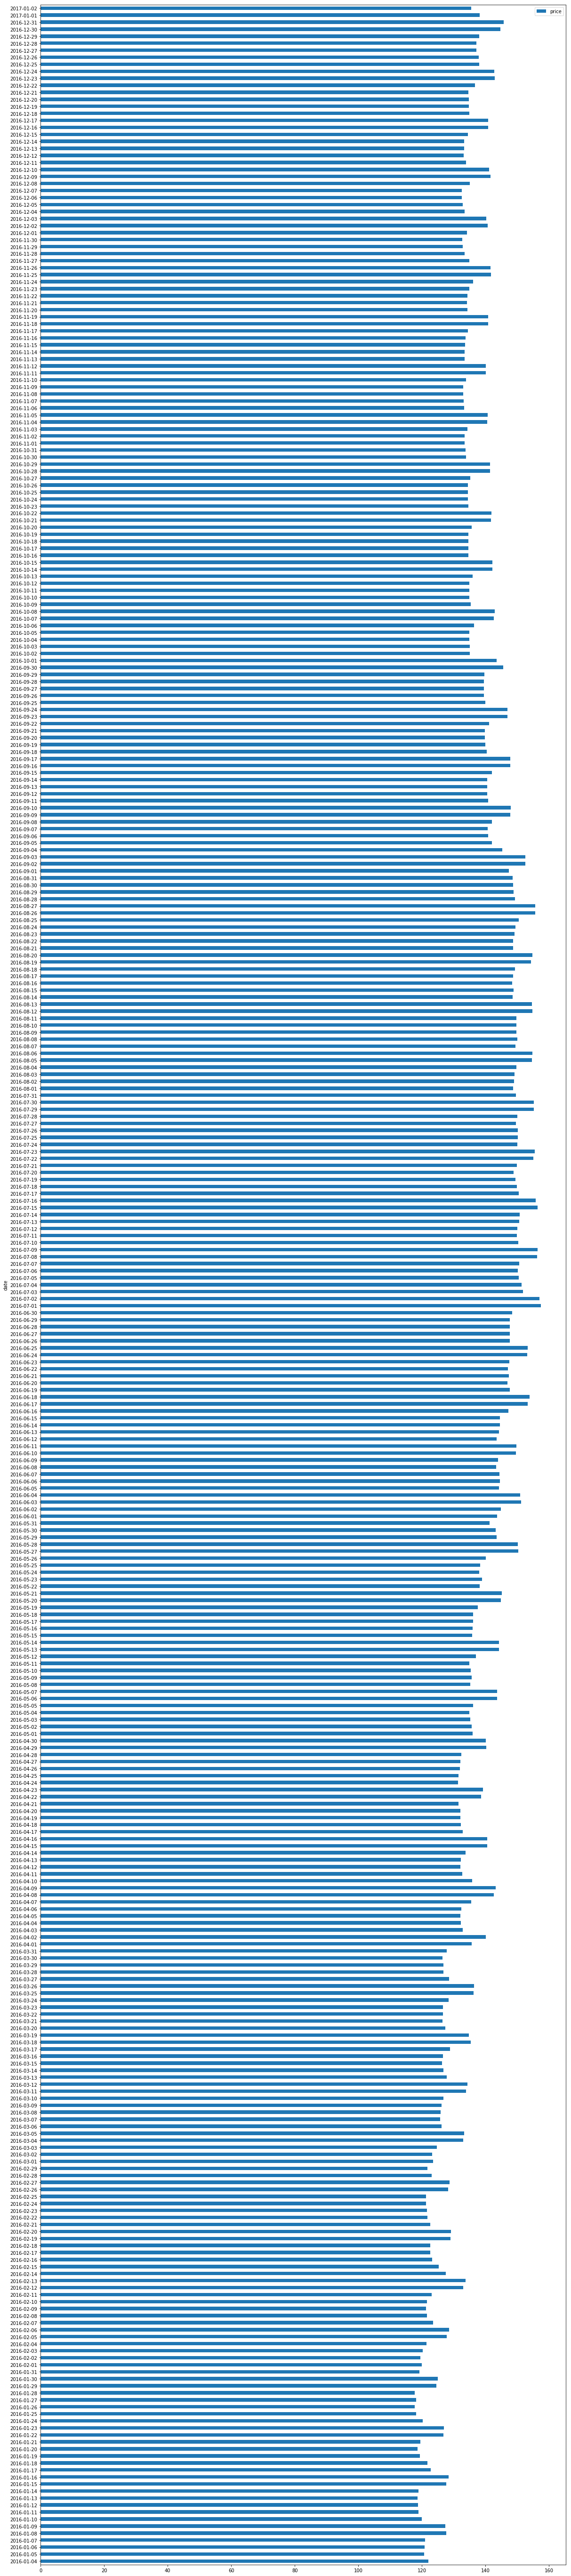

In [6]:
# Since we have A Nan values, we will do a query that calculate the mean of prices grouping by date when the price is available.
mean_of_day = pd.DataFrame(calendar.query("available == 't'").groupby
                           (['date']).mean()['price'])
mean_of_day.plot(kind = 'barh',figsize = (20,100));

Nice, we can see here how prices change during all the year, is was started with lowest price and increased with time.

Also we can see how the price reach to highest price the week in weekends also this pattern happened whole the year.

Now let's see how which is the seasons in Seattle, but frist we need to fix date column

In [7]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [8]:
mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B'),
                                 sort=False)['price'].mean()

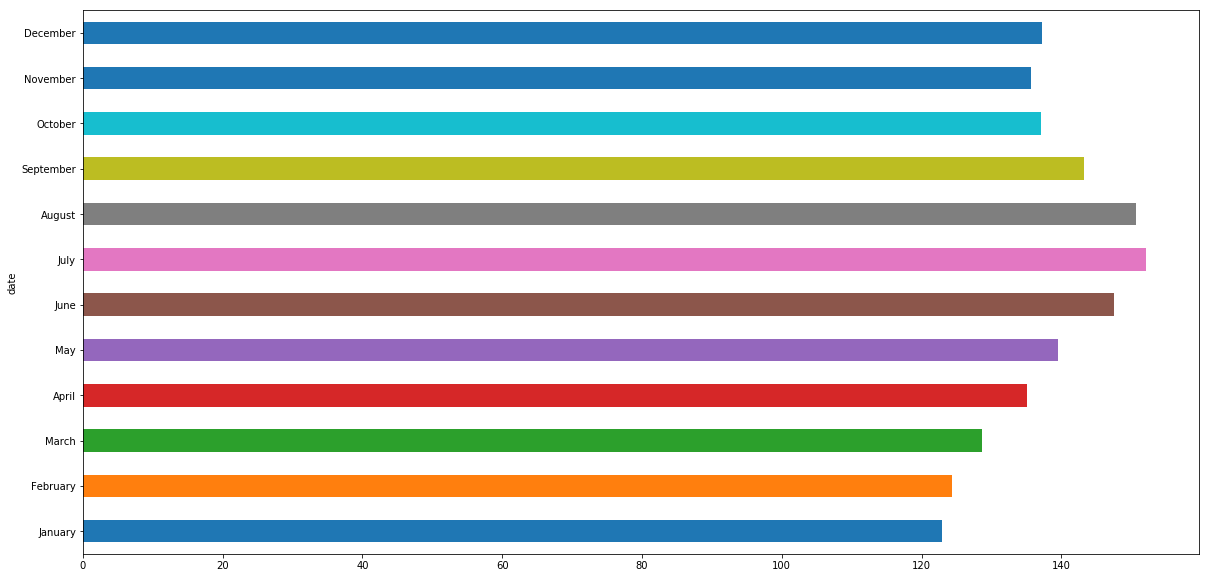

In [9]:
mean_of_month.plot(kind = 'barh' , figsize = (20,10));

AHA ! We can see how the price of houses increases in the months of June, July and August.

Let's compare the quarters and see the comparison.

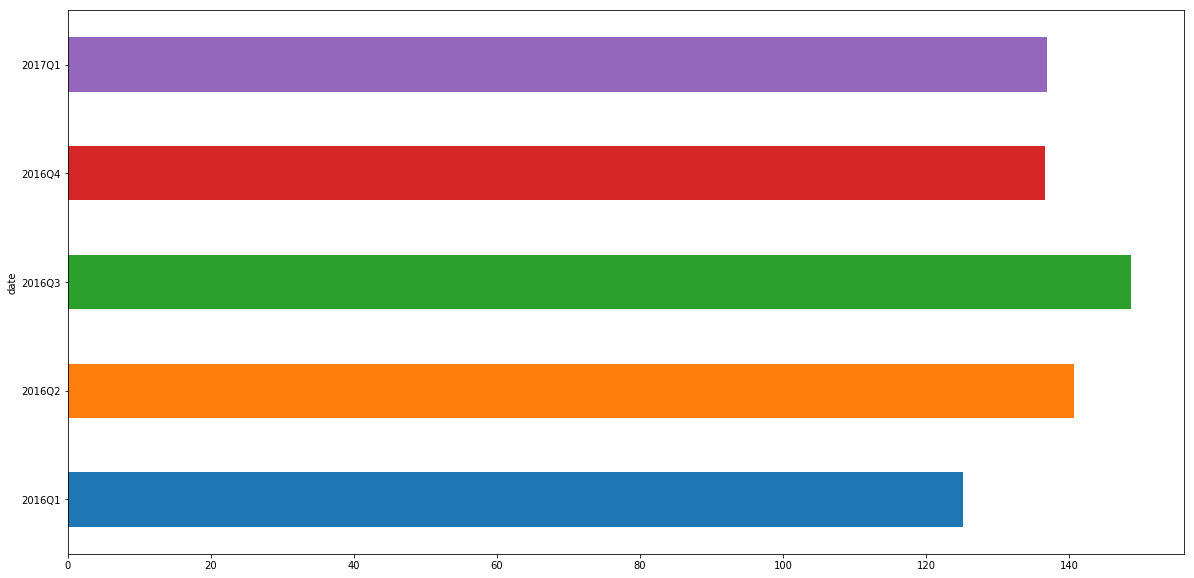

In [10]:
mean_of_quarter = calendar.groupby(pd.PeriodIndex(calendar['date'],
                                                  freq='Q'))['price'].mean()
mean_of_quarter.plot(kind = 'barh' , figsize = (20,10));

## Seattle AirBnb Hosts Neighbourhood

In [11]:
listings = pd.read_csv('listings.csv')

In [12]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [13]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

We can see here a there 92 columns and there a lot of features that will help us this analysis but at now we will focuses on following important features:
* neighbourhood, neighbourhood_cleansed, zipcode
* property_type, room_type

In [14]:
columns_loc = ['id', 'neighbourhood', 'neighbourhood_cleansed',
               'zipcode', 'property_type', 'room_type', 'price']

listings_loc = listings[columns_loc]
listings_loc.head()

,id,neighbourhood,neighbourhood_cleansed,zipcode,property_type,room_type,price
0,241032,Queen Anne,West Queen Anne,98119,Apartment,Entire home/apt,$85.00
1,953595,Queen Anne,West Queen Anne,98119,Apartment,Entire home/apt,$150.00
2,3308979,Queen Anne,West Queen Anne,98119,House,Entire home/apt,$975.00
3,7421966,Queen Anne,West Queen Anne,98119,Apartment,Entire home/apt,$100.00
4,278830,Queen Anne,West Queen Anne,98119,House,Entire home/apt,$450.00


In [15]:
listings_loc.describe(include='all')

,id,neighbourhood,neighbourhood_cleansed,zipcode,property_type,room_type,price
count,3.818000e+03,3402,3818,3811,3817,3818,3818
unique,NaN,81,87,28,16,3,273
top,NaN,Capitol Hill,Broadway,98122,House,Entire home/apt,$150.00
freq,NaN,351,397,420,1733,2541,162
mean,5.550111e+06,NaN,NaN,NaN,NaN,NaN,NaN
std,2.962660e+06,NaN,NaN,NaN,NaN,NaN,NaN
min,3.335000e+03,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.258256e+06,NaN,NaN,NaN,NaN,NaN,NaN
50%,6.118244e+06,NaN,NaN,NaN,NaN,NaN,NaN
75%,8.035127e+06,NaN,NaN,NaN,NaN,NaN,NaN



 property_type 



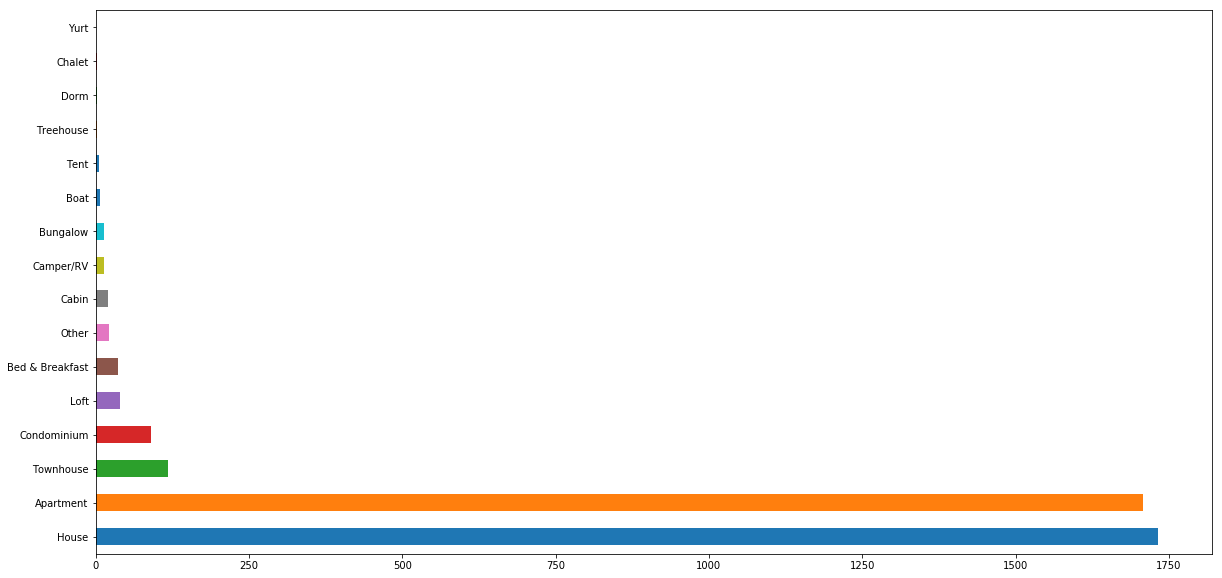

In [16]:
count_values_cols = ['neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type']

def plot_values_counts (col):
    print('\n', col ,'\n' )
    listings_loc[col].value_counts().plot(kind = 'barh' , figsize = (20,10));
    
plot_values_counts ('property_type')
    

Nice, after we underdtand how these houses spread, let's do some important steps to before starting:

* Fix price as we did with calendar
* Engineering in the feature property_type since (Cabin, camper/rv ...) are have few values and we can merge them with other.
* We need to drop neighbourhood, zipcode since neighbourhood_cleansed is more efficient and don't have any missing values.

In [17]:
fix_prices('price', listings_loc)
fix_numeric('price', listings_loc)

C:\Users\Khaled\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Khaled\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [18]:
listings_loc.describe()

,id,price
count,3.818000e+03,3818.000000
mean,5.550111e+06,127.976166
std,2.962660e+06,90.250022
min,3.335000e+03,20.000000
25%,3.258256e+06,75.000000
50%,6.118244e+06,100.000000
75%,8.035127e+06,150.000000
max,1.034016e+07,1000.000000


In [19]:
# This will replace any value that repated 30 times or less to ''other''

prop_tp = listings_loc['property_type'].value_counts()
for c in range(len(prop_tp)):
    val = prop_tp.values[c] 
    ind = prop_tp.index[c]
    if val <= 30:
        listings_loc['property_type']=listings_loc['property_type'].replace(ind,'Other');

C:\Users\Khaled\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
listings_loc = listings_loc.drop(['neighbourhood', 'zipcode'] , axis = 1)

In [21]:
listings_loc.head()

,id,neighbourhood_cleansed,property_type,room_type,price
0,241032,West Queen Anne,Apartment,Entire home/apt,85.0
1,953595,West Queen Anne,Apartment,Entire home/apt,150.0
2,3308979,West Queen Anne,House,Entire home/apt,975.0
3,7421966,West Queen Anne,Apartment,Entire home/apt,100.0
4,278830,West Queen Anne,House,Entire home/apt,450.0


In [110]:
neigh_count = pd.DataFrame()
neigh_count['count'] = listings_loc['neighbourhood_cleansed'].value_counts()
neigh_mean = pd.DataFrame()
neigh_mean['mean_price'] = listings_loc.groupby(listings_loc['neighbourhood_cleansed'])['price'].mean()
neighbourhood_info = pd.merge(neigh_mean, neigh_count, left_on = neigh_mean.index,right_on = neigh_count.index)

In [137]:
neighbourhood_info.index = neighbourhood_info.key_0

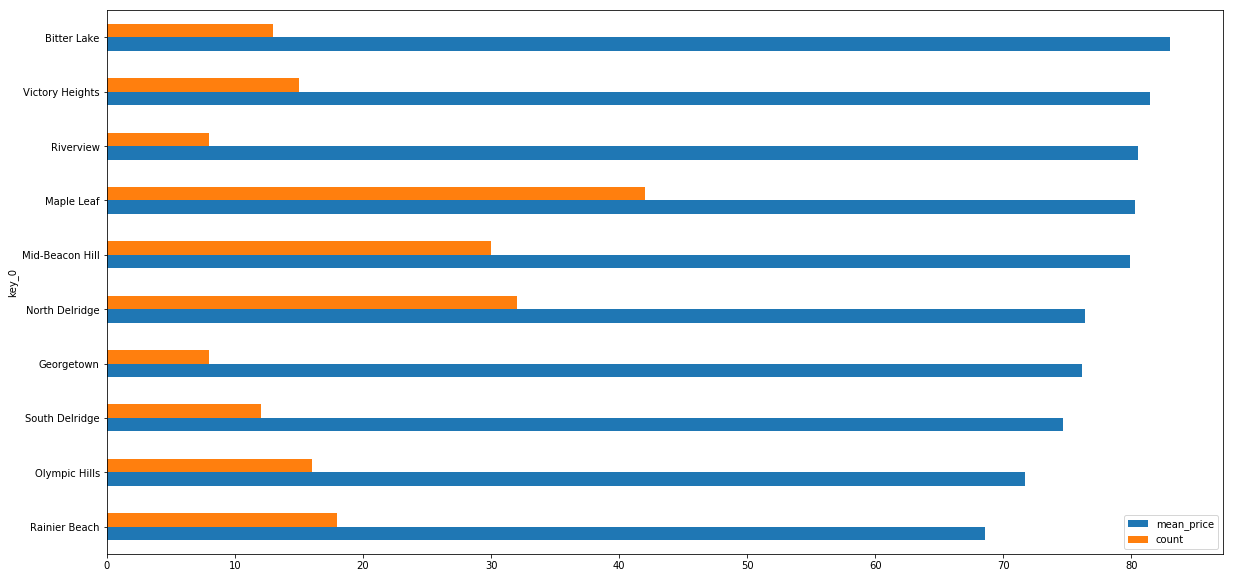

In [138]:
neighbourhood_info.sort_values(by = 'mean_price' ).iloc[0:10].plot(kind = 'barh',figsize = (20,10));

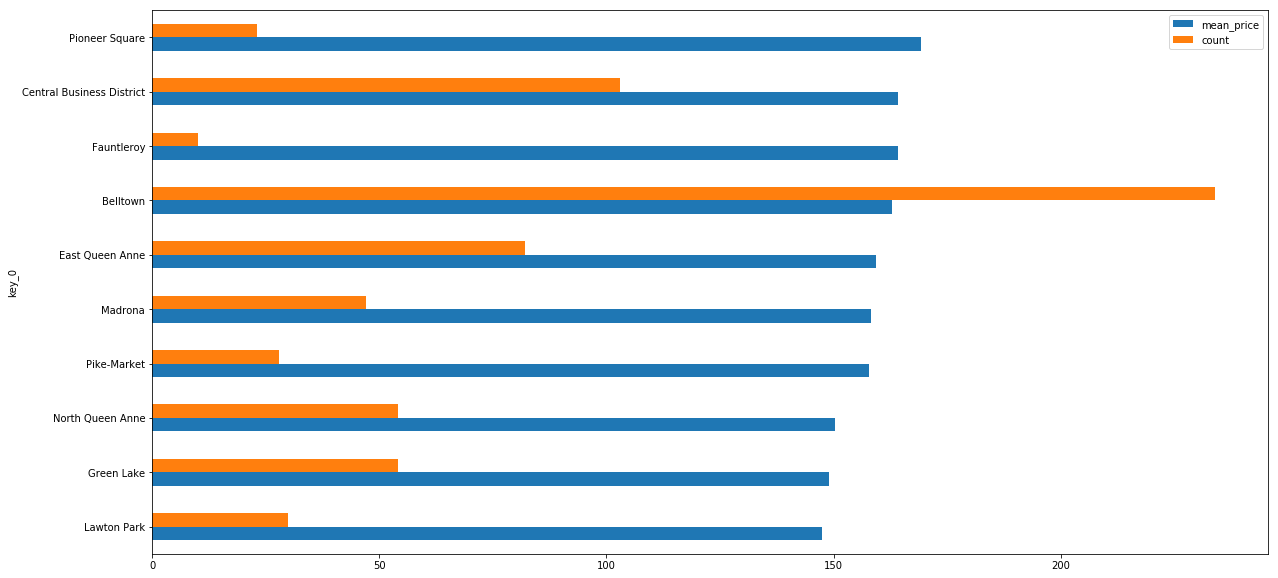

In [139]:
neighbourhood_info.sort_values(by = 'mean_price').iloc[67:-10].plot(kind = 'barh',figsize = (20,10));

Great ! we can see here the highest neighbourhood in Seattle are (Pioneer Square, Central Business DistrictFauntleroy) and lowest neighbourhood are (Rainier Beach, Olympic Hills, South Delridge)

## Relationships Of Features With Price In Seattle

Now we have seen and understand a lot of things about Seattle homes datasets, we want now to see how to building predictive model that can understaing the features and predict the price of each home based on it's features.

We will use listings dataset and we will do a lot of features enginering to reach to our goal let's start.

In [24]:
object_cols = []
non_object_cols = []
for colid in range(listings.shape[1]):
    col_name = listings.columns[colid]
    col_data_type = listings[col_name].dtypes
    if col_data_type == 'object':
        object_cols.append(col_name)
    else : non_object_cols.append(col_name)

print('Number of object type is', len(object_cols), 'Number of non object type is:', len(non_object_cols) )

Number of object type is 62 Number of non object type is: 30


Now we want to understaning how this features spread and thier nan's values

In [25]:
hist_unique = []
hist_null = []

for col_name in object_cols:
    count_unique_val = listings[col_name].value_counts().count()
    col_null_count = listings[col_name].isnull().sum()
    hist_unique.append(count_unique_val)
    hist_null.append(col_null_count)

In [26]:
hist_unique_non_object_cols = []
hist_null_non_object_cols = []

for col_name in non_object_cols:
    count_unique_val = listings[col_name].value_counts().count()
    col_null_count = listings[col_name].isnull().sum()
    hist_unique_non_object_cols.append(count_unique_val)
    hist_null_non_object_cols.append(col_null_count)

In [27]:
def plot_list(dataframe, title):
    ''' Take a dataframe and title then plot them
    '''
    plt.figure(figsize =(20,10))
    plt.title(title)
    plt.xticks(np.arange(min(dataframe), max(dataframe), 70))
    plt.hist(dataframe, bins = np.arange(min(dataframe), max(dataframe) + 70, 70) , facecolor='blue')
    plt.show();

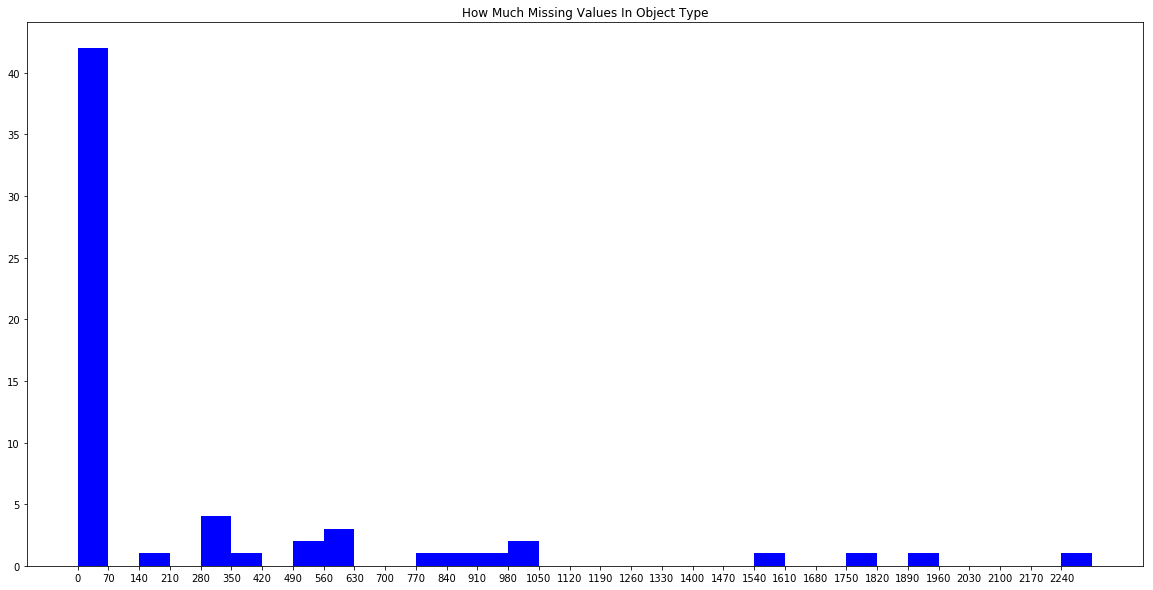

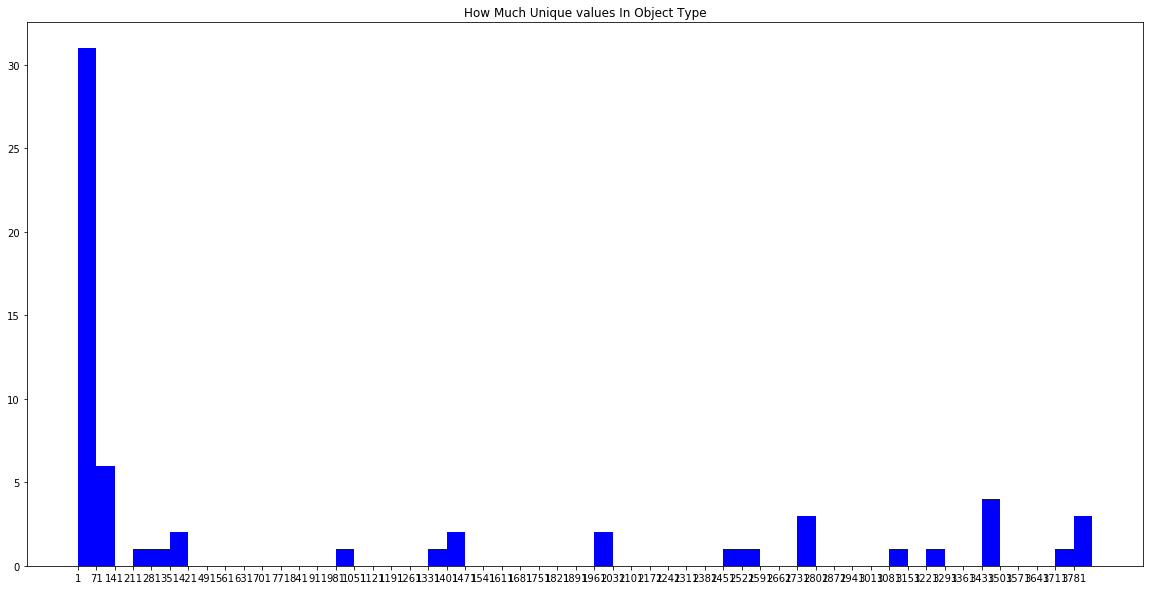

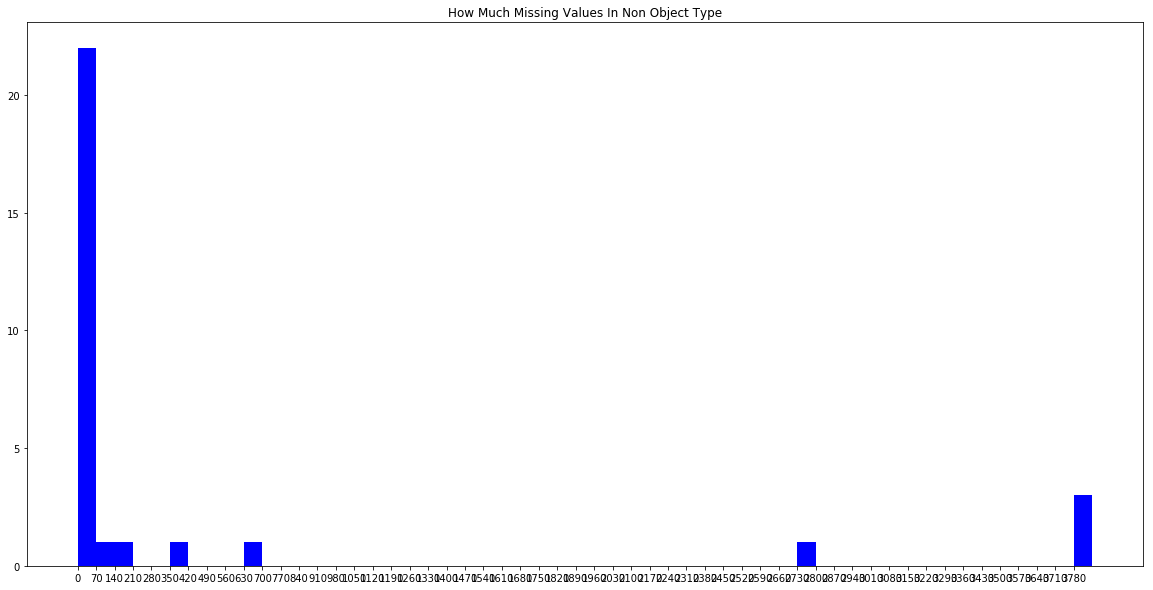

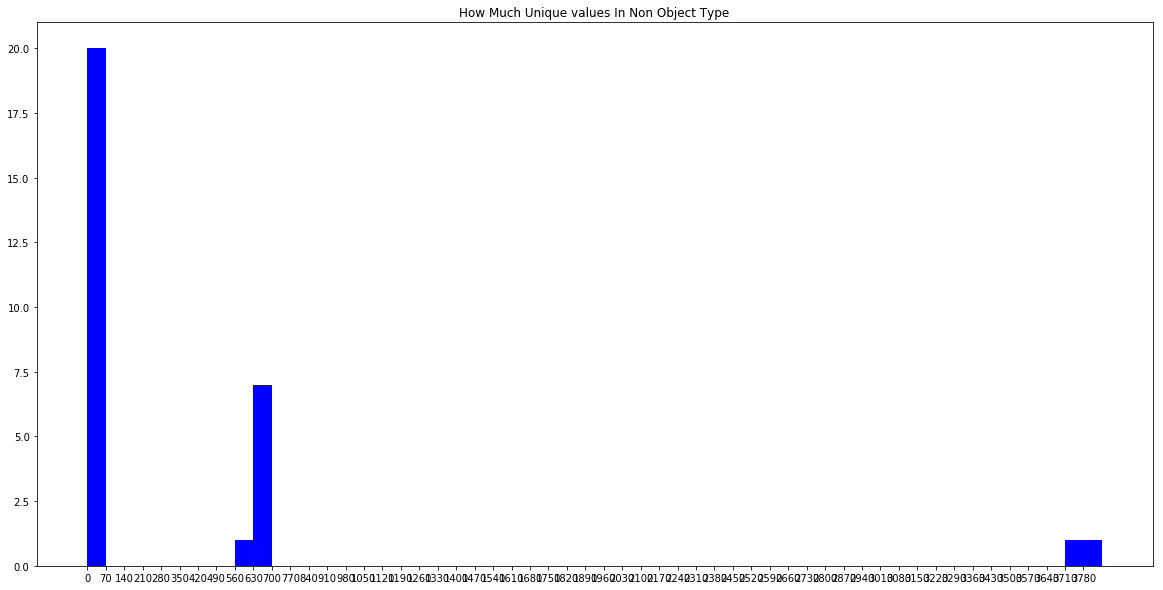

In [28]:
plot_list(hist_null, 'How Much Missing Values In Object Type')
plot_list(hist_unique, 'How Much Unique values In Object Type')
plot_list(hist_unique_non_object_cols, 'How Much Missing Values In Non Object Type')
plot_list(hist_null_non_object_cols, 'How Much Unique values In Non Object Type')

In [29]:
for col_name in object_cols:
    count_unique_val = (listings[col_name].value_counts().count() / listings.shape[0]) * 100
    col_null_count = (listings[col_name].isnull().sum() / listings.shape[0]) * 100
    if col_null_count >= 30:
        print(col_name, col_null_count, '% Have of missing data')
    if count_unique_val >= 30:
        print(col_name, count_unique_val, '% Have of unique data')

listing_url 100.0 % Have of unique data
name 99.31901519119958 % Have of unique data
summary 91.09481403876374 % Have of unique data
space 81.69198533263489 % Have of unique data
description 98.00942902042954 % Have of unique data
neighborhood_overview 65.63645887899425 % Have of unique data
notes 42.063907805133574 % Have of missing data
notes 52.35725510738607 % Have of unique data
transit 67.41749607124149 % Have of unique data
thumbnail_url 91.61864850707177 % Have of unique data
medium_url 91.61864850707177 % Have of unique data
picture_url 100.0 % Have of unique data
xl_picture_url 91.61864850707177 % Have of unique data
host_url 72.05343111576742 % Have of unique data
host_name 38.397066526977476 % Have of unique data
host_since 36.144578313253014 % Have of unique data
host_about 52.671555788370874 % Have of unique data
host_thumbnail_url 71.8438973284442 % Have of unique data
host_picture_url 71.8438973284442 % Have of unique data
street 37.76846516500786 % Have of unique data


In [30]:
for col_name in non_object_cols:
    count_unique_val = (listings[col_name].value_counts().count() / listings.shape[0]) * 100
    col_null_count = (listings[col_name].isnull().sum() / listings.shape[0]) * 100
    if col_null_count >= 30:
        print(col_name, col_null_count, '% Have of missing data')
    if count_unique_val >= 30:
            print(col_name, count_unique_val, '% Have of unique data')

id 100.0 % Have of unique data
host_id 72.05343111576742 % Have of unique data
latitude 100.0 % Have of unique data
longitude 100.0 % Have of unique data
square_feet 97.45940282870613 % Have of missing data
license 100.0 % Have of missing data


Nice , now we will create a new dataset and we will remove any columns that will not add a lot of information and we will handle categorical and missing data

In [31]:
new_lis = listings
new_lis = new_lis.drop(['square_feet', 'license', 'picture_url', 'listing_url',
                        'name', 'description', 'experiences_offered', 'latitude',
                        'longitude'], axis=1)

In [32]:
def engineering_01 (column_name, dataset_name, method):
    ''' Take a column_name, dataset_name and method numbers
    And based on method we will engineering the feature
    '''
    # For saving changes
    count_1s,count_0s, count_nan = 0,0,0

    # For counting nan's
    count_nan = dataset_name[column_name].isnull().sum()

    # For counting value counts in the feacture
    feature_value_counts = dataset_name[column_name].value_counts()

    for ind in range(len(feature_value_counts)):
        val = feature_value_counts.values[ind]
        ind = feature_value_counts.index[ind]

        # If method = 1 this will change repated value to 1 and non repated values to 0

        if method == 1:
            if val > 1:
                dataset_name[column_name]= dataset_name[column_name].replace(ind,1)
                count_1s = count_1s + val

            if val == 1:
                dataset_name[column_name]= dataset_name[column_name].replace(ind,0)
                count_0s = count_0s + val

        # If method = 0 this will change values to 1 and if nan will treat leater with -1

        if method == 0:
            dataset_name[column_name]= dataset_name[column_name].replace(ind,1)
            count_1s = count_1s + val

    print('For col {}, we have changed {} values to 1 , {} to 0, and {} to -1'.format(column_name, count_1s, count_0s, count_nan))
    dataset_name[column_name] = dataset_name[column_name].fillna(-1)


In [33]:
col_repate = ['host_id', 'summary', 'space','thumbnail_url',
              'neighborhood_overview', 'transit', 'medium_url',
              'xl_picture_url' , 'host_url', 'host_name', 'host_about',
              'host_thumbnail_url', 'amenities', 'host_picture_url']
col_null = ['notes', 'weekly_price', 'monthly_price', 'security_deposit',
            'host_response_time', 'host_acceptance_rate']


# Fix repated values and null values
    
for col1 in col_repate:
    engineering_01 (col1, new_lis, 1)
for col2 in col_null:
    engineering_01 (col2, new_lis, 0)

For col host_id, we have changed 1533 values to 1 , 2285 to 0, and 0 to -1
For col summary, we have changed 251 values to 1 , 3390 to 0, and 177 to -1
For col space, we have changed 196 values to 1 , 3053 to 0, and 569 to -1
For col thumbnail_url, we have changed 0 values to 1 , 3498 to 0, and 320 to -1
For col neighborhood_overview, we have changed 434 values to 1 , 2352 to 0, and 1032 to -1
For col transit, we have changed 458 values to 1 , 2426 to 0, and 934 to -1
For col medium_url, we have changed 0 values to 1 , 3498 to 0, and 320 to -1
For col xl_picture_url, we have changed 0 values to 1 , 3498 to 0, and 320 to -1
For col host_url, we have changed 1533 values to 1 , 2285 to 0, and 0 to -1
For col host_name, we have changed 2930 values to 1 , 886 to 0, and 2 to -1
For col host_about, we have changed 1352 values to 1 , 1607 to 0, and 859 to -1
For col host_thumbnail_url, we have changed 1540 values to 1 , 2276 to 0, and 2 to -1
For col amenities, we have changed 833 values to 1 ,

In [34]:
# Reduce host_since values and remove days
reduce_date = ['first_review' , 'last_review', 'host_since']
for col in reduce_date:
    new_lst = new_lis[col].value_counts()
    for l in range(len(new_lst)):
        val = new_lst.values[l]
        ind = new_lst.index[l]
        new_lis[col]=new_lis[col].replace(ind,ind[:-6])

print ("We have removed days, monthes columns in following 'first_review' , 'last_review', 'host_since' to reduce features")


We have removed days, monthes columns in following 'first_review' , 'last_review', 'host_since' to reduce features


In [35]:
# Reduce host_nighbourhood with less features

new_lst = new_lis['host_neighbourhood'].value_counts()
for l in range(len(new_lst)):
    val = new_lst.values[l]
    ind = new_lst.index[l]
    if val <= 20:
        new_lis['host_neighbourhood']=new_lis['host_neighbourhood'].replace(ind,1)

print ("We have reduced features of host_neighbourhood")


We have reduced features of host_neighbourhood


In [36]:
# Reduce values of street

new_lis['street'] = new_lis['street'].str.split(',').str[0]
new_lst = new_lis['street'].value_counts()

for l in range(len(new_lst)):
    val = new_lst.values[l]
    ind = new_lst.index[l]
    if val < 11:
        new_lis['street']=new_lis['street'].replace(ind,'others')
        
print ('We have change any street that repated in our dataset less than 11')

We have change any street that repated in our dataset less than 11


In [37]:
# Fix some data in our columns

new_lis['zipcode']=new_lis['zipcode'].replace('99\n98122','98122')
new_lis['cleaning_fee'] = new_lis['cleaning_fee'].str.replace('$','').str.replace(',','')
new_lis['price'] = new_lis['price'].str.replace('$','').str.replace(',','')
new_lis['extra_people'] = new_lis['extra_people'].str.replace('$','').str.replace(',','')

# If host from seattle will change to true, if not to 0

new_lis['host_location'] = new_lis['host_location'].str.contains('Seattle')

# fix host_response_rate to numbers

new_lis['host_response_rate'] = new_lis['host_response_rate'].str.replace('%','')

print('We have fixed values in following columns extra_people, price, cleaning_fee, zipcode,host_response_rate, host_location')


We have fixed values in following columns extra_people, price, cleaning_fee, zipcode,host_response_rate, host_location


In [38]:
# Reduce calendar updated features

new_lst = new_lis['calendar_updated'].value_counts()
for l in range(len(new_lst)):
    val = new_lst.values[l]
    ind = new_lst.index[l]
    if 'days' in ind or 'week' in ind:
        new_lis['calendar_updated']=new_lis['calendar_updated'].replace(ind,'week')
    if 'months' in ind :
        new_lis['calendar_updated']=new_lis['calendar_updated'].replace(ind,'months')
    if 'yesterday' in ind:
        new_lis['calendar_updated']=new_lis['calendar_updated'].replace(ind,'today')
                                                              
print('We have updated values in calendar_updated')

We have updated values in calendar_updated


In [39]:
fill_nans = ['host_location','host_response_rate','host_is_superhost',
             'host_neighbourhood','host_has_profile_pic', 'host_since',
             'host_identity_verified' , 'neighbourhood', 'zipcode',
            'property_type', 'cleaning_fee', 'first_review' , 'last_review' ]
for col3 in fill_nans:
    count_nan = new_lis[col3].isnull().sum()
    new_lis[col3] = new_lis[col3].fillna(-1)
    print(col3, "we have fixed", count_nan, 'nan data and changed to -1' )

host_location we have fixed 8 nan data and changed to -1
host_response_rate we have fixed 523 nan data and changed to -1
host_is_superhost we have fixed 2 nan data and changed to -1
host_neighbourhood we have fixed 300 nan data and changed to -1
host_has_profile_pic we have fixed 2 nan data and changed to -1
host_since we have fixed 2 nan data and changed to -1
host_identity_verified we have fixed 2 nan data and changed to -1
neighbourhood we have fixed 416 nan data and changed to -1
zipcode we have fixed 7 nan data and changed to -1
property_type we have fixed 1 nan data and changed to -1
cleaning_fee we have fixed 1030 nan data and changed to -1
first_review we have fixed 627 nan data and changed to -1
last_review we have fixed 627 nan data and changed to -1


In [40]:
to_numeric = ['cleaning_fee', 'price', 'extra_people', 'host_response_rate' ]
for col_n in to_numeric:
    new_lis[col_n] = pd.to_numeric(new_lis[col_n])
print("We have changed following to numeric type 'cleaning_fee', 'price', 'extra_people', 'host_response_rate' ")

We have changed following to numeric type 'cleaning_fee', 'price', 'extra_people', 'host_response_rate' 


In [41]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorizer (column_name, dataset_name):
    ''' Take a column_name, dataset_name 
    will engineering the feature and create bag of words 
    '''
    vectorizer = CountVectorizer()
    vectorizer_data = vectorizer.fit_transform(dataset_name[column_name]).toarray()
    vectorizer_names = vectorizer.get_feature_names()
    names_vectors = []
    new_name = column_name + '_'
    for name in vectorizer_names:
        names_vectors.append(new_name + name)
    df = pd.DataFrame(vectorizer_data, columns = names_vectors)
    for col in df.columns:
        sum_cols =  df[col].sum() / df.shape[0]
        if sum_cols < 0.3:
            df = df.drop(col, axis = 1)
    dataset_name = dataset_name.join(df)

    return dataset_name

In [42]:
pre_final = vectorizer ('host_verifications', new_lis)

In [43]:
pre_final = pre_final.drop('host_verifications', axis = 1)

In [44]:
object_cols = []
non_object_cols = []
for colid in range(pre_final.shape[1]):
    col_name = pre_final.columns[colid]
    col_data_type = pre_final[col_name].dtypes
    if col_data_type == 'object':
        object_cols.append(col_name)
    else : non_object_cols.append(col_name)

print('Number of object type is', len(object_cols), 'Number of non object type is:', len(non_object_cols) )

Number of object type is 33 Number of non object type is: 55


In [45]:
for col_n in object_cols:
    count_unique_val = pre_final[col_n].value_counts().count()
    if count_unique_val == 1:
        pre_final = pre_final.drop(col_n, axis = 1)
        print('We have drop',col_n, 'due is have one value')

We have drop last_scraped due is have one value
We have drop market due is have one value
We have drop country_code due is have one value
We have drop country due is have one value
We have drop has_availability due is have one value
We have drop calendar_last_scraped due is have one value
We have drop requires_license due is have one value
We have drop jurisdiction_names due is have one value


In [46]:
pre_final = pre_final.drop('state', axis = 1)

In [47]:
object_cols = []
non_object_cols = []
for colid in range(pre_final.shape[1]):
    col_name = pre_final.columns[colid]
    col_data_type = pre_final[col_name].dtypes
    if col_data_type == 'object':
        object_cols.append(col_name)
    else : non_object_cols.append(col_name)
        
for col_n in object_cols:
    count_unique_val = pre_final[col_n].value_counts().count()
    if count_unique_val == 2:
        pre_final[col_n]=pre_final[col_n].replace('t',1)
        pre_final[col_n]=pre_final[col_n].replace('f',0)
        pre_final[col_n] = pd.to_numeric(pre_final[col_n])
        print(col_n, 'hase change to numeric')

is_location_exact hase change to numeric
instant_bookable hase change to numeric
require_guest_profile_picture hase change to numeric
require_guest_phone_verification hase change to numeric


In [48]:
pre_final['host_location'] = pre_final['host_location'].replace('True',1)
pre_final['host_location'] = pre_final['host_location'].replace('False',0)
pre_final['host_location'] = pd.to_numeric(pre_final['host_location'])
pre_final['host_is_superhost'] = pre_final['host_is_superhost'].replace('t',1)
pre_final['host_is_superhost'] = pre_final['host_is_superhost'].replace('f',0)
pre_final['host_is_superhost'] = pd.to_numeric(pre_final['host_is_superhost'])
pre_final['host_has_profile_pic'] = pre_final['host_has_profile_pic'].replace('t',1)
pre_final['host_has_profile_pic'] = pre_final['host_has_profile_pic'].replace('f',0)
pre_final['host_has_profile_pic'] = pd.to_numeric(pre_final['host_has_profile_pic'])
pre_final['host_identity_verified'] = pre_final['host_identity_verified'].replace('t',1)
pre_final['host_identity_verified'] = pre_final['host_identity_verified'].replace('f',0)
pre_final['host_identity_verified'] = pd.to_numeric(pre_final['host_identity_verified'])

print('host_is_superhost, host_has_profile_pic, host_identity_verified has been changed to numeric')

host_is_superhost, host_has_profile_pic, host_identity_verified has been changed to numeric


In [49]:
pre_final = pre_final.drop(['neighbourhood', 'neighbourhood_group_cleansed', 'city', 'smart_location'], axis = 1)

In [50]:
object_cols = []
non_object_cols = []
for colid in range(pre_final.shape[1]):
    col_name = pre_final.columns[colid]
    col_data_type = pre_final[col_name].dtypes
    if col_data_type == 'object':
        object_cols.append(col_name)
    else : non_object_cols.append(col_name)
object_cols

['host_since',
 'host_neighbourhood',
 'street',
 'neighbourhood_cleansed',
 'zipcode',
 'property_type',
 'room_type',
 'bed_type',
 'calendar_updated',
 'first_review',
 'last_review',
 'cancellation_policy']

In [65]:
final = pre_final
for col_name in object_cols:
    df = pd.get_dummies(final[col_name], prefix=col_name , drop_first=True)
    final = final.join(df)
    final = final.drop(col_name, axis=1)
    print(col_name)

host_since
host_neighbourhood
street
neighbourhood_cleansed
zipcode
property_type
room_type
bed_type
calendar_updated
first_review
last_review
cancellation_policy


In [66]:
object_cols = []
non_object_cols = []
for colid in range(final.shape[1]):
    col_name = final.columns[colid]
    col_data_type = final[col_name].dtypes
    if col_data_type == 'object':
        object_cols.append(col_name)
    else : non_object_cols.append(col_name)

null_non_object_cols = []

for col_name in non_object_cols:
    col_null_count = final[col_name].isnull().sum()
    hist_null_non_object_cols.append(col_null_count)
    if col_null_count >= 1:
        final[col_name] = final[col_name].fillna(final[col_name].mean())

So good, now we have completed all necessry work in cleaning the data before building the predictive model.

we

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [74]:
y = final['price']
X = final.drop(['price','id','scrape_id', 'cleaning_fee', 'extra_people'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

In [75]:
ForestRegressor = RandomForestRegressor(n_estimators=500)
ForestRegressor.fit(X_train, y_train)
y_test_preds = ForestRegressor.predict(X_test)
print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_test, y_test_preds))
print(median_absolute_error(y_test, y_test_preds))

0.6045140146453774
3386.763648581284
20.503


We can see here there a close error to 19$ in our model which is not smart and accurcy so good but is can capture some of valuable information from our dataset, let's see now  the feature importances (the higher, the more important the feature).

In [76]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = ForestRegressor.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,est_int,coefs
26,bedrooms,0.370015
25,bathrooms,0.081557
24,accommodates,0.062373
51,reviews_per_month,0.036723
288,room_type_Private room,0.029523
38,availability_365,0.020514
289,room_type_Shared room,0.017519
32,guests_included,0.012589
162,neighbourhood_cleansed_Belltown,0.012070
39,number_of_reviews,0.012020


In [143]:
coefs_df.index = coefs_df.est_int

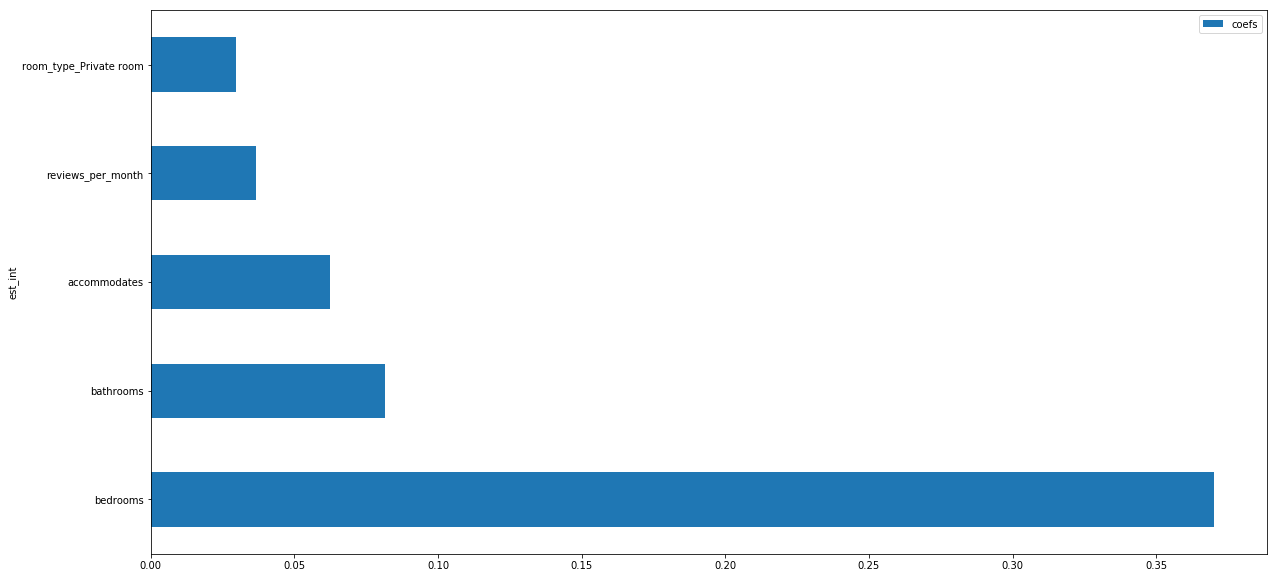

In [144]:
coefs_df.sort_values('coefs', ascending=False).head(5).plot(kind = 'barh',figsize = (20,10));